# Testing the ML model on the full dataset

In [ ]:
import joblib
import pandas as pd

In [ ]:
data = pd.read_csv('/content/Impact_of_Remote_Work_on_Mental_Health.csv')
data

,Employee_ID,Age,Gender,Job_Role,Industry,Years_of_Experience,Work_Location,Hours_Worked_Per_Week,Number_of_Virtual_Meetings,Work_Life_Balance_Rating,Stress_Level,Mental_Health_Condition,Access_to_Mental_Health_Resources,Productivity_Change,Social_Isolation_Rating,Satisfaction_with_Remote_Work,Company_Support_for_Remote_Work,Physical_Activity,Sleep_Quality,Region
0,EMP0001,32,Non-binary,HR,Healthcare,13,Hybrid,47,7,2,Medium,Depression,No,Decrease,1,Unsatisfied,1,Weekly,Good,Europe
1,EMP0002,40,Female,Data Scientist,IT,3,Remote,52,4,1,Medium,Anxiety,No,Increase,3,Satisfied,2,Weekly,Good,Asia
2,EMP0003,59,Non-binary,Software Engineer,Education,22,Hybrid,46,11,5,Medium,Anxiety,No,No Change,4,Unsatisfied,5,NaN,Poor,North America
3,EMP0004,27,Male,Software Engineer,Finance,20,Onsite,32,8,4,High,Depression,Yes,Increase,3,Unsatisfied,3,NaN,Poor,Europe
4,EMP0005,49,Male,Sales,Consulting,32,Onsite,35,12,2,High,NaN,Yes,Decrease,3,Unsatisfied,3,Weekly,Average,North America
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,EMP4996,32,Male,Sales,Consulting,4,Onsite,24,2,5,High,Burnout,Yes,Decrease,4,Neutral,1,Weekly,Average,Asia
4996,EMP4997,39,Female,Sales,Healthcare,27,Onsite,48,15,1,Low,Depression,Yes,Decrease,1,Satisfied,1,NaN,Average,Africa
4997,EMP4998,42,Female,Sales,Healthcare,21,Hybrid,34,1,4,High,Burnout,No,Increase,3,Satisfied,1,Daily,Poor,Oceania
4998,EMP4999,27,Female,Sales,Healthcare,26,Remote,58,0,5,Low,NaN,Yes,Increase,3,Unsatisfied,4,Daily,Average,Asia


In [ ]:
# import sklearn
# print(sklearn.__version__)

In [ ]:
#pip install scikit-learn==1.5.2
# ensure to use the same version of sklearn to avoid any error for using this model

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import numpy as np


class CustomImputer(BaseEstimator, TransformerMixin):
    def __init__(self, cat_columns, impute_values, column_to_drop):
        self.cat_columns = cat_columns
        self.impute_values = impute_values
        self.column_to_drop = column_to_drop

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()  # Create a copy of the DataFrame to avoid modifying the original
        # Impute specified values for the specified columns
        for col, val in zip(self.cat_columns, self.impute_values):
            X[col] = X[col].fillna(val)

        # Drop specified columns
        X = X.drop(columns=self.column_to_drop, errors='ignore')  # errors='ignore' to avoid error if column doesn't exist

        return X

class PreprocessingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, num_attribs, cat_attribs, custom_imputer_cols, column_to_drop):
        self.num_attribs = num_attribs
        self.cat_attribs = cat_attribs
        self.custom_imputer_cols = custom_imputer_cols
        self.column_to_drop = column_to_drop

    def fit(self, X, y=None):
        # Fit numerical pipeline
        self.num_pipeline_ = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', MinMaxScaler()),
        ])
        self.num_pipeline_.fit(X[self.num_attribs])

        # Fit categorical pipeline
        self.cat_pipeline_ = Pipeline([
            ('custom_imputer', CustomImputer(cat_columns=self.custom_imputer_cols,
                                           impute_values=['Others', 'Monthly'],
                                           column_to_drop=self.column_to_drop)),
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore')),
        ])
        self.cat_pipeline_.fit(X[self.cat_attribs])

        return self

    def transform(self, X, y=None):
        # Transform numerical features
        X_num = self.num_pipeline_.transform(X[self.num_attribs])

        # Transform categorical features
        X_cat = self.cat_pipeline_.transform(X[self.cat_attribs])

        # Concatenate transformed features
        X_transformed = np.concatenate([X_num, X_cat], axis=1)

        return X_transformed

    def get_feature_names_out(self, input_features=None):
        # Get numerical feature names
        num_feature_names = self.num_pipeline_.get_feature_names_out(self.num_attribs)

        # Get categorical feature names
        cat_feature_names = self.cat_pipeline_.named_steps['encoder'].get_feature_names_out(self.cat_attribs)

        # Combine all feature names
        all_feature_names = list(num_feature_names) + list(cat_feature_names)

        return all_feature_names

In [ ]:
num_attribs = ['Age', 'Years_of_Experience', 'Hours_Worked_Per_Week',
                    'Number_of_Virtual_Meetings', 'Work_Life_Balance_Rating',
                    'Social_Isolation_Rating', 'Company_Support_for_Remote_Work']
cat_attribs = ['Gender', 'Job_Role', 'Industry', 'Work_Location',
                    'Mental_Health_Condition', 'Access_to_Mental_Health_Resources',
                    'Productivity_Change', 'Satisfaction_with_Remote_Work',
                    'Physical_Activity', 'Sleep_Quality']
custom_imputer_cols = ['Mental_Health_Condition', 'Physical_Activity']
column_to_drop = ['Employee_ID', 'Region']

In [ ]:
model = joblib.load('/content/my_stress_level_classifier.pkl')
predictions = model.predict(data)

In [ ]:
print(predictions.shape)

(5000,)


In [ ]:
y_test = data['Stress_Level']

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

accuracy_score = accuracy_score(y_test, predictions)
precision_score = precision_score(y_test, predictions, average='weighted')
recall_score = recall_score(y_test, predictions, average='weighted')
f1_score = f1_score(y_test, predictions, average='weighted')

print(f"Accuracy Score: {accuracy_score}")
print(f"Precision Score: {precision_score}")
print(f"Recall Score: {recall_score}")
print(f"F1 Score: {f1_score}")

Accuracy Score: 0.8526
Precision Score: 0.853227807216056
Recall Score: 0.8526
F1 Score: 0.8526546807115879


In [ ]:
confusion_matrix = confusion_matrix(y_test, predictions)
print("Confusion Matrix:")
print(confusion_matrix)

Confusion Matrix:
[[1465  106  115]
 [ 142 1384  119]
 [ 159   96 1414]]


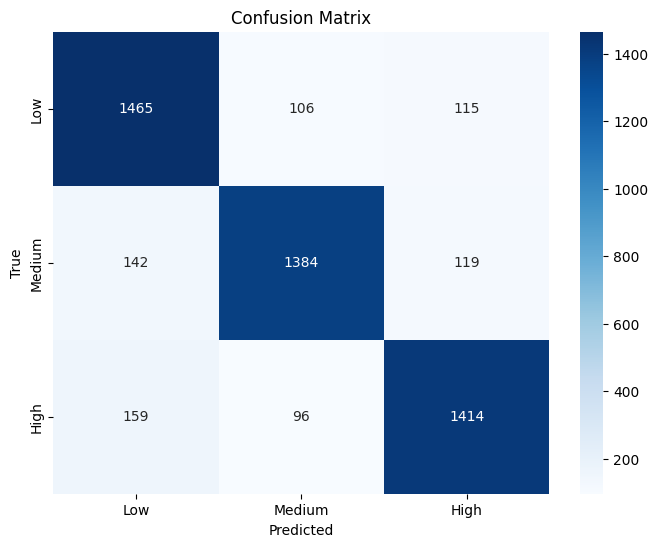

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, predictions)

# plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',  xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
plt.tight_layout()

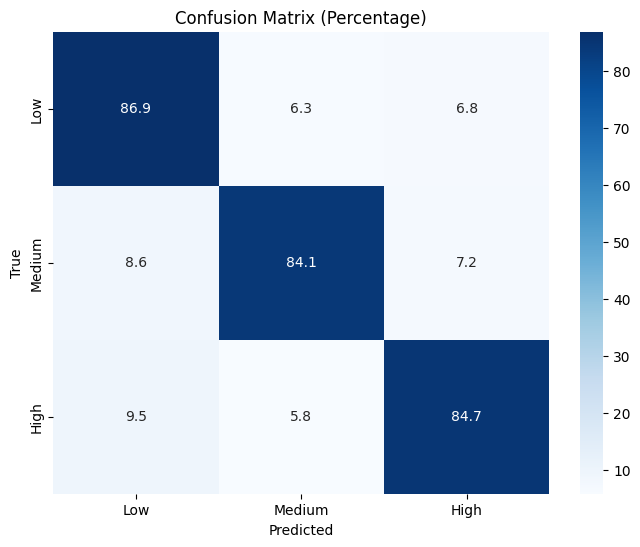

<Figure size 640x480 with 0 Axes>

In [ ]:
# Convert the confusion matrix to percentage values
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# plot the confusion matrix using seaborn with percentage values
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percentage, annot=True, fmt=".1f", cmap='Blues',  xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Percentage)')
plt.show()
plt.tight_layout()